# Ánalisis de sentimientos

Trabajo realizado por Gonzalo Campos Mejías y Alejandro Medina Durán

## Índice

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#0">Importado de dependencias</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#1">1. Recopilación de datos</a></strong> </span></p>

<p style="text-align: left;"> </p>
<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#2">2. Eliminación de palabras que no aportan información</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#3">3. Etiquetado de datos</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#4">4. Validación de la predicción realizada</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#5">5. Entrenamiento del modelo</a></strong> </span></p>
- <a href="#5.1">Validación cruzada</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#6">6. Predicción de tweets</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#7">7. Análisis de tweets de personajes públicos</a></strong> </span></p>

<a name="0"></a>
## <span style="color:black">Importado de dependencias</span>

En la siguiente celda se incluyen todas las importaciones que serán necesarias para la ejecución del proyecto. Estas importaciones se usarán para realizar diversas tareas relacionadas con el procesamiento de texto, etiquetado de datos, vectorización de texto utilizando TF-IDF, entrenamiento y evaluación de modelos de clasificación utilizando diferentes algoritmos de aprendizaje automático, preprocesamiento de datos utilizando sklearn.preprocessing y generación de gráficos utilizando matplotlib.

In [2]:
# Utilidad
import pandas
import numpy
import csv

# Procesado de texto
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Etiquetado de datos
from textblob import TextBlob

# TF-IDF vectorization

from sklearn import naive_bayes
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

# Sklearn
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import MaxAbsScaler

# Graphs
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aleme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aleme\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


<a name="1"></a>
## <span style="color:black">1. Recopilación de datos</span>

En primer lugar haremos uso de pandas para la lectura de los tweets que serán utilizados posteriormente para la aplicación de distintos algoritmos de aprendizaje automático. Estos tweets están almacenados en un csv llamado _"tweets.csv"_ en el cual únicamente se encuentran los mensajes en la columna "text". Estos datos han sido obtenidos a través de Kaggle de donde se han seleccionado los tweets a usar para el proyecto.

In [3]:
DATASET_COLUMNS = ["text"]
DATASET_ENCODING = 'ISO-8859-1'

dataset = pandas.read_csv('tweets.csv',encoding=DATASET_ENCODING, names=DATASET_COLUMNS, skiprows=1)

Haciendo uso de la función "shape" podemos ver el número de filas y columnas del csv leído.

In [4]:
print(dataset.shape)

(88035, 1)


La función "head" nos muestra el número de tweets que le indiquemos, en este caso mostraremos los primeros 10.

In [5]:
dataset.head(10)

,text
0,I hate when I have to call and wake people up
1,@oanhLove I hate when that happens...
2,sleep soon... i just hate saying bye and see y...
3,"I miss you twitter. My phone broke, now I'm us..."
4,I just saw that they found that Tracy girl in ...
5,Think I'm going to bed. Goodniight. I hate this
6,stupid movies we watched... mirrors ugggggh......
7,Waiting at the airport for my ride while I get...
8,@frago I hate you. I didn't need to see that. ...
9,"My bathtub drain is fired: it haz 1 job 2 do, ..."


<a name="2"></a>
## <span style="color:black">2. Eliminación de palabras que no aportan información</span>

En este apartado de hará uso de la librería NLTK (Natural Language Toolkit) para crear una función llamada _limpiar_texto_, la cual se encargará de: eliminar palabras comunes que aporten poca información (stop words), menciones, hashtags, URLs y cualquier otro símbolo. Se utilizarán técnicas de lematización y tokenización, son técnicas comunes utilizadas en el procesamiento de texto para simplificar y estructurar los datos de texto.

La tokenización se refiere al proceso de dividir un texto en unidades más pequeñas llamadas tokens, es útil para separar el texto en elementos significativos, lo que facilita el análisis posterior.
La lematización es el proceso de reducir las palabras a su forma base, que se conoce como lema, ayuda a reducir la dimensionalidad del vocabulario, ya que varias formas de una palabra se agrupan en una sola forma base, lo que simplifica el análisis y mejora la eficiencia del modelo.

Con el objetivo de limpiar correctamente los datos se han definido los siguientes patrones:

MENTION_PATTERN = r'@[A-Za-z0-9_]+':
Este patrón se utiliza para encontrar menciones en el texto que comienzan con el símbolo "@" seguido de letras, números y guiones bajos.

HASHTAG_PATTERN = r'#\w+':
Este patrón se utiliza para encontrar hashtags en el texto que comienzan con el símbolo "#" seguido de una o más letras, números o guiones bajos.

URL_PATTERN = r'http\S+|www\S+|https\S+':
Este patrón se utiliza para encontrar URLs en el texto. Puede identificar URLs que comienzan con "http://", "www." o "https://", seguidos de cualquier combinación de caracteres que no sean espacios en blanco.

NONALPHA_PATTERN = r'[^a-zA-Z\s]':
Este patrón se utiliza para encontrar cualquier carácter que no sea una letra o un espacio en blanco en el texto. Se utiliza para eliminar símbolos, puntuación u otros caracteres que no son relevantes para el análisis de texto.

sequencePattern = r"(.)\1\1+":
Este patrón se utiliza para encontrar secuencias de tres o más caracteres repetidos consecutivamente en el texto. Se utiliza para identificar repeticiones excesivas de letras o caracteres en una palabra, como "loooovee" o "coooool".

seqReplacePattern = r"\1\1":
Este patrón se utiliza para reemplazar las secuencias de tres o más caracteres repetidos consecutivamente por solo dos repeticiones del mismo carácter. Se utiliza para simplificar las palabras y reducir la cantidad de caracteres repetidos en el texto, como convertir "looooong" a "loong" o "coooool" a "cool".

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

MENTION_PATTERN = r'@[A-Za-z0-9_]+'
HASHTAG_PATTERN = r'#\w+'
URL_PATTERN = r'http\S+|www\S+|https\S+'
NONALPHA_PATTERN = r'[^a-zA-Z\s]'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

In [7]:
def limpiar_texto(text):
    
    text = text.lower()

    text = re.sub(MENTION_PATTERN, '', text)
    text = re.sub(HASHTAG_PATTERN,'', text)
    text = re.sub(URL_PATTERN, '', text)
    text = re.sub(NONALPHA_PATTERN, ' ', text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    text = text.strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            
    return " ".join(tokens)

A continuación se aplica _limpiar_texto_ a los tweets.

In [8]:
dataset.text = dataset.text.apply(lambda x: limpiar_texto(x))

Mostramos los 10 primeros tweets de la lista a modo de ejemplo para comprobar que el método funciona correctamente, se pueden comparar con los mensajes originales mostrados en el apartado _1. Recopilación de datos_.

In [9]:
for i in range(10):
    print(dataset.text[i])

hate call wake people
hate happens
sleep soon hate saying bye see tomorrow night
miss twitter phone broke using stupid nokia phone ughh miss advance phone
saw found tracy girl piece luggage fucking terrible
think going bed goodniight hate
stupid movie watched mirror uggh stoopeed rip
waiting airport ride get harassed men trying sell ugly hat want sleep
hate need see need call therapist
bathtub drain fired haz job amp iz fail got drano as amp iz still draining wan na shower dangit


<a name="3"></a>
## <span style="color:black">3. Etiquetado de datos</span>

Se usará la librería TextBlob para etiquetar los tweets. Se etiquetan según la polaridad del mensaje, cuanto mas se acerque la polaridad a -1 es más negativo, si es 0 es neutro y, cuanto más se acerque a 1 más positivo es. Para este caso vamos a considerar un tweet como "Muy feliz" si la polaridad es mayor a 0.65, "Contento" si es menor que 0.65 mayor a 0.3, "Neutro" si está entre 0.3 y -0.3, "Molesto" si está entre -0.3 y -0.65, y "Hater" si la polaridad es menor a -0.65.

Estos valores pueden modificarse ya que sirven para realizar una primera aproximación para la clasificación de los tweets, que luego se tendrán que corregir de forma manual.

Los resultados se guardarán en un archivo llamado _classified_tweets.csv_.

In [10]:
classified_tweets = []

for line in dataset.text:
    blob = TextBlob(line)
    polaridad = blob.sentiment.polarity
    
    if polaridad > 0.65:
        label = 'Muy feliz'
    elif polaridad > 0.3:
        label = 'Contento'
    elif polaridad > -0.3:
        label = 'Neutro'
    elif polaridad > -0.65:
        label = 'Molesto'
    else:
        label = 'Hater'
    
    classified_tweets.append([line, label])

with open('classified_tweets.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['text', 'label'])
    writer.writerows(classified_tweets)

<a name="4"></a>
## <span style="color:black">4. Validación de la predicción realizada</span>

Para la validación de las etiquetas se revisarán manualmente las asignadas en el paso anterior a cada tweet. Se genera así los datos de entrenamiento y prueba, que se encuentran en _reviewed_tweets.csv_.

In [11]:
dataset_reviewed = pandas.read_csv('reviewed_tweets.csv',encoding=DATASET_ENCODING, names=["text", "label"], skiprows=1)
text, label = list(dataset_reviewed['text']), list(dataset_reviewed['label'])

Tras la revisión de los datos se obtiene la siguiente proporción.

In [12]:
print(pandas.Series(label).value_counts(normalize=True))

Hater        0.227182
Neutro       0.227182
Contento     0.227182
Muy feliz    0.227182
Molesto      0.091271
dtype: float64


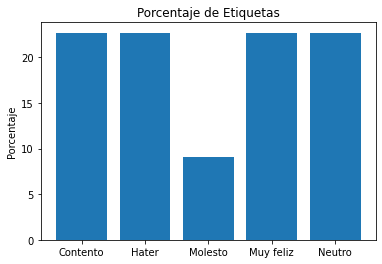

In [13]:
codificador_objetivo = preprocessing.LabelEncoder()
objetivo_codificado = codificador_objetivo.fit_transform(label)

# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = pandas.Series(objetivo_codificado).value_counts()

# Obtener los porcentajes de cada etiqueta
porcentajes = conteo_etiquetas / len(label) * 100

plt.bar(porcentajes.index, porcentajes)
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Etiquetas')
etiquetas = codificador_objetivo.inverse_transform(porcentajes.index)
plt.xticks(porcentajes.index, etiquetas)

plt.show()

<a name="5"></a>
## <span style="color:black">5. Entrenamiento del modelo</span>

Para poder usar los algoritmos de aprendizaje automático, se deben entrenar los modelos con los tweets ya clasificados. Para ello se realiza la división de los datos en conjuntos de entrenamiento y prueba utilizando la función train_test_split de scikit-learn, a la que se le pasan los mensajes limpios junto a sus correspondientes etiquetas, definiendo que un 20% de los datos serán de prueba siendo el otro 80% usado para el entrenamiento. Con random_state = 0 se establece la semilla para el generador de números aleatorios utilizado por train_test_split, al establecerlo en 0, se asegura que siempre se obtendrá la misma división si se ejecuta varias veces.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset.text.values.tolist(), label,
                                                    test_size = 0.2, random_state = 0)

TfidfVectorizer: Esta es una clase de scikit-learn que se utiliza para convertir una colección de documentos de texto en una matriz TF-IDF, es una medida que asigna pesos a las palabras en función de su frecuencia en un documento y en todo el corpus. Esto permite capturar la importancia relativa de una palabra en un documento en comparación con el corpus completo.

ngram_range=(1, 3): Este parámetro especifica el rango de n-gramas que se utilizarán al construir las características. En este caso, se utilizarán n-gramas de tamaño 1 (unigrama), 2 (bigrama) y 3 (trigrama). Esto significa que se considerarán secuencias de una a tres palabras consecutivas como características.

sublinear_tf=True: Este parámetro aplica una transformación logarítmica a la frecuencia de término para suavizar la escala. Esto ayuda a evitar una sobrevaloración de palabras que aparecen con alta frecuencia en el texto.

use_idf=True: Este parámetro especifica si se debe utilizar la ponderación IDF (Inverse Document Frequency) en la matriz TF-IDF. La ponderación IDF asigna un peso más alto a las palabras menos frecuentes y un peso más bajo a las palabras más frecuentes en el corpus.

Con vectoriser.fit(X_train) se ajusta el vectorizador a los datos de entrenamiento X_train. Esto significa que el vectorizador analizará los textos de entrenamiento y aprenderá el vocabulario y las estadísticas necesarias para construir la matriz TF-IDF.

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),sublinear_tf=True, use_idf=True)
vectorizer.fit(X_train)

TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True)

Se aplica la transformación del vectorizador TF-IDF a los conjuntos de entrenamiento y prueba.

In [16]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

<a name="5.1"></a>
### <span style="color:black">Validación cruzada</span>

Se separan de los datos de _reviewed_sample.csv_ el conjunto de entrenamiento y de prueba. La validación cruzada consiste en dividir los datos en un número de pliegues "cv". Por ejemplo, si se establece cv=5, los datos se dividirán en 5 pliegues o partes iguales. Luego, el modelo se entrenará y evaluará 5 veces, utilizando cada vez un pliegue diferente como conjunto de prueba y el resto de los pliegues como conjunto de entrenamiento. Este parámetro puede modificarse en cada uno de los algoritmos, sus valores se han establecido según su eficiencia al ser algunos más costosos computacionalmente que otros.

El rendimiento del modelo se evalúa para cada pliegue y se devuelve una lista de puntuaciones de rendimiento correspondientes a cada iteración. Estas puntuaciones se pueden utilizar para calcular una métrica agregada, como la media, que proporciona una estimación del rendimiento general del modelo. Se usará el modelo cuya precisión sea mayor

In [17]:
# Entrenar y evaluar el modelo Naive Bayes
naive_bayes = MultinomialNB()
scores_naive_bayes = cross_val_score(naive_bayes, X_train, y_train, cv=15)
precision_media_naive_bayes = scores_naive_bayes.mean()

print("Precisión media Naive Bayes:", precision_media_naive_bayes)

Precisión media Naive Bayes: 0.7519169268598598


In [18]:
# Entrenar y evaluar el modelo Árbol de Decisión
arbol_decision = DecisionTreeClassifier()
scores_arbol_decision = cross_val_score(arbol_decision, X_train, y_train, cv=2)
precision_media_arbol_decision = scores_arbol_decision.mean()

print("Precisión media Árbol de Decisión:", precision_media_arbol_decision)

Precisión media Árbol de Decisión: 0.8451610155051967


In [19]:
# Entrenar y evaluar el modelo kNN

# Para mejorar la precisión se escala las características al rango [-1, 1] dividiendo cada valor por el valor máximo absoluto en la columna correspondiente
scaler = MaxAbsScaler() 
X_train_scaled = scaler.fit_transform(X_train)

# Selección de características relevantes
selector = SelectKBest(score_func=f_classif, k=150)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

knn = KNeighborsClassifier(n_neighbors=120)
scores_knn = cross_val_score(knn, X_train_selected, y_train, cv=7)
precision_media_knn = scores_knn.mean()

print("Precisión media kNN:", precision_media_knn)

Precisión media kNN: 0.762438330262972


In [20]:
# Entrenar y evaluar el modelo linearSVC
linear_svc = LinearSVC()
scores_linear_svc = cross_val_score(linear_svc, X_train, y_train, cv=15)
precision_media_linear_svc = scores_linear_svc.mean()

print("Precisión media LinearSVC:", precision_media_linear_svc)

Precisión media LinearSVC: 0.849406532738986


In [21]:
# Entrenar y evaluar el modelo complement naive bayes
complement_nb = ComplementNB()
scores_complement_nb = cross_val_score(complement_nb, X_train, y_train, cv=10)
precision_media_complement_nb = scores_complement_nb.mean()

print("Precisión media ComplementNB:", precision_media_complement_nb)

Precisión media ComplementNB: 0.772050907874995


In [22]:
# Entrenar y evaluar el modelo de regresión logística
logistic_regression = LogisticRegression(max_iter=1000)
scores_logistic_regression = cross_val_score(logistic_regression, X_train, y_train, cv=2)
precision_media_logistic_regression = scores_logistic_regression.mean()

print("Precisión media regresión logística:", precision_media_logistic_regression)

Precisión media regresión logística: 0.8121343783722383


Después de obtener los resultados anteriores comparamos las precisiones y cogemos el modelo con mayor precision.

In [23]:
mejor_modelo = max(precision_media_naive_bayes, precision_media_arbol_decision, precision_media_knn,
                   precision_media_linear_svc, precision_media_complement_nb,precision_media_logistic_regression)

if mejor_modelo == precision_media_naive_bayes:
    modelo = naive_bayes
elif mejor_modelo == precision_media_arbol_decision:
    modelo = arbol_decision
elif mejor_modelo == precision_media_knn:
    modelo = knn
elif mejor_modelo == precision_media_linear_svc:
    modelo = linear_svc
elif mejor_modelo == precision_media_complement_nb:
    modelo = complement_nb
elif mejor_modelo == precision_media_logistic_regression:
    modelo = logistic_regression
    
print("el mejor modelo tras aplicar validación cruzada es:",modelo)

el mejor modelo tras aplicar validación cruzada es: LinearSVC()


Tras la ejecución de los algoritmos se puede ver que naive bayes y complement naive bayes tienen una buena precisión, un 75% aproximadamente cada uno, además comparando con los demás modelos se puede decir que ambos son eficientes. Ambos son algoritmos de aprendizaje supervisado utilizados para tareas de clasificación, son rápidos y simples. La principal diferencia entre Naive Bayes y Complement Naive Bayes radica en la forma en que manejan el desequilibrio de clases en los conjuntos de datos.
Naive Bayes es un algoritmo que asume independencia condicional entre las características dado el valor de la variable objetivo. Sin embargo, en el caso de conjuntos de datos desequilibrados, donde una clase tiene muchos más ejemplos que la otra, Naive Bayes puede verse afectado por el sesgo hacia la clase mayoritaria y tener dificultades para clasificar correctamente la clase minoritaria.

Para abordar este problema, el algoritmo Complement Naive Bayes es una variante de Naive Bayes que intenta compensar el sesgo hacia la clase mayoritaria. En lugar de modelar directamente la distribución de cada clase, Complement Naive Bayes modela la distribución de la clase minoritaria en lugar de la clase mayoritaria.La idea es que, al modelar la clase minoritaria, se puede mejorar la capacidad del algoritmo para discriminar la clase minoritaria y equilibrar el efecto del desequilibrio de clases. Esto puede conducir a una mejora en la precisión en conjuntos de datos desequilibrados en comparación con el Naive Bayes estándar.

El modelo de knn tiene una precisión del 76% después de aplicar el escalado, lo que sumado a la selección de características  han servido para proporcionar una precisión aceptable para este modelo, que en versiones anteriores donde no se han aplicado ninguna de las dos la precisión era considerablemente menor. Es un algoritmo de aprendizaje supervisado utilizado para problemas de clasificación y regresión, donde su precisión puede variar dependiendo del conjunto de datos y los parámetros seleccionados

Sin embargo, hay tres modelos que tienen una alta precisión: LinearSVC, Árbol de Decisiones y regresión logística, aunque entre ellos hemos encontrado diferencias cuando hablamos de eficiencia al ejecutarlos:

 - En cuanto al modelo de regresión logística se trata de un algoritmo que ofrece una buena precisión, sobre el 81%, y no es tan costoso cuando hablamos de eficiencia como otros, aunque tampoco es el mejor. Esto se puede deber a que la Regresión Logística asume una relación lineal entre las características y el resultado. Sin embargo, el análisis de sentimientos en textos puede involucrar relaciones más complejas y sutiles entre las palabras y las emociones. Esto puede resultar en una limitación del poder predictivo del algoritmo, lo que podría explicar una precisión del 81% en lugar de un rendimiento aún más alto. También,  debido a la naturaleza lineal del modelo puede enfrentar dificultades cuando se le proporciona un gran número de datos y el riesgo de sobreajuste.

 - Respecto a la diferencia de eficiencia entre LinearSVC y Árbol de Decisiones, a pesar de que ambos modelos tienen una alta precisión (85% aproximadamente), el Árbol de Decisiones es menos eficiente en términos de velocidad de entrenamiento y tiempo de predicción. Esto se debe a que el Árbol de Decisiones puede construir estructuras de árbol más complejas, lo que puede llevar a una mayor complejidad computacional.

 - Por otro lado, LinearSVC utiliza técnicas de optimización más eficientes para resolver el problema de clasificación, lo que puede resultar en un entrenamiento y predicción más rápidos. LinearSVC utiliza una formulación basada en SVM (Support Vector Machine (Máquina de Vectores de Soporte), es un algoritmo de aprendizaje supervisado utilizado tanto para tareas de clasificación como de regresión, se utiliza comúnmente en problemas de clasificación) que busca encontrar un hiperplano de separación óptimo para clasificar las muestras. Esta formulación puede funcionar bien en problemas linealmente separables o en aquellos donde un hiperplano de separación lineal sea una buena aproximación. En tales casos, el LinearSVC puede lograr una alta precisión.

<a name="6"></a>
## <span style="color:black">6. Predicción de tweets</span>

Utilizando el modelo con mejor rendimiento se va a predecir el sentimiento de los tweets del conjunto de pruebas

In [24]:
if mejor_modelo == precision_media_naive_bayes:
    
    naive_bayes = MultinomialNB()
    naive_bayes.fit(X_train, y_train) # Entrenar el modelo Naive Bayes

    predicciones = naive_bayes.predict(X_test) # Realizar predicciones en el conjunto de prueba
    
    precision = accuracy_score(y_test, predicciones) # Calcular la precisión del modelo
    modelo = naive_bayes # guardamos el modelo para no tener que entrenarlo de nuevo en el punto 7
    print("Precisión del modelo Naive Bayes:", precision)
    
elif mejor_modelo == precision_media_arbol_decision:

    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train) 
    
    predicciones = decision_tree.predict(X_test) 
    
    precision = accuracy_score(y_test, predicciones)
    modelo = decision_tree
    print("Precisión del modelo Árbol de Decisión:", precision)
    
elif mejor_modelo == precision_media_knn:
    
    scaler = MaxAbsScaler() 
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    selector = SelectKBest(score_func=f_classif, k=150)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    knn = KNeighborsClassifier(n_neighbors=120)

    knn.fit(X_train_selected, y_train)

    predicciones = knn.predict(X_test_selected)

    precision = accuracy_score(y_test, predicciones)
    modelo = knn
    print("Precisión del modelo kNN:", precision)
    
elif mejor_modelo == precision_media_linear_svc:
    linearSVC = LinearSVC()
    linearSVC.fit(X_train, y_train)

    predicciones = linearSVC.predict(X_test)

    precision = accuracy_score(y_test, predicciones)
    modelo = linearSVC
    print("Precisión del modelo LinearSVC:", precision)
    
elif mejor_modelo == precision_media_complement_nb:
    cnb = ComplementNB()
    cnb.fit(X_train, y_train)

    predicciones = cnb.predict(X_test)

    precision = accuracy_score(y_test, predicciones)
    modelo = cnb
    print("Precisión del modelo complement Naive Bayes:", precision)

elif mejor_modelo == precision_media_logistic_regression:
    
    logistic_regression = LogisticRegression(max_iter=1000)
    logistic_regression.fit(X_train, y_train)

    predicciones = logistic_regression.predict(X_test)

    precision = accuracy_score(y_test, predicciones)
    modelo = logistic_regression
    print("Precisión de la Regresión Logística:", precision)

Precisión del modelo LinearSVC: 0.8645425115011075


Tras ejecutar el algoritmo con los datos de prueba y entrenamiento definidos arriba se puede observar que tiene una precisión muy alta, a lo que si se suma su rápida ejecución, se puede decir que LinearSVC es un modelo de aprendizaje automático muy efectivo cuando se trata de categorizar los sentimientos de textos.

Una precisión del 87% aproximadamente es bastante buena y muestra un rendimiento sólido del modelo en la tarea de clasificación de sentimientos. Esto indica que el modelo pudo aprender patrones relevantes en los datos de entrenamiento y generalizarlos correctamente en el conjunto de prueba.

Una alta precisión del 87% sugiere que el modelo es capaz de capturar eficientemente las características distintivas de los textos y clasificarlos correctamente en categorías de sentimientos. Esto es un indicio de que LinearSVC es una opción sólida para la clasificación de sentimientos.

<a name="7"></a>
## <span style="color:black">7. Análisis de tweets de personajes públicos</span>

Se recopilarán los últimos 30 tweets de dos personas conocidas en redes sociales, una de ella conocida por ser hater y la otra por ser más positiva. Con estos tweets el objetivo es analizarlos con el mejor modelo obtenido en el paso anterior para llegar a la conclusión de si la buena o mala fama que tienen está reflejada también en sus publicaciones.

Se añadirá un pie chart para ver visualmente el estado de ánimo de estas personas respecto a sus tweets publicados.

Debido a que no usamos la api de Twitter, la obtención de estos tweets se hará manualmente entrando en las cuentas de estas dos personas. En concreto vamos a analizar los tweets de @AlexGoldberg_ (hater) y @PostMalone (persona con valoración social positiva)

In [25]:
# Obtener los últimos 30 tweets de la persona con mala fama (hater)
lista_tweets_hater = ['Happy or Jack Grealish. Gets so much shit for just being a real person with personality. Can’t imagine the state he’s gonna be in for the next 72 hours… and good for him, lol.',
                     'I HATE that Man City have now won a CL, hate it, but you gotta be in awe of Pep Guardiola, man. We are witnessing one of the greatest managers any sport will ever have, he sets the bar & keeps on raising it. He’s unbelievable.',
                     'Ok Rom, you’re about to have a one night stand in my heart. Do your thing, big man….',
                     'Lukaku loves sabotaging his own teams.',
                     'Anyone getting all serious saying “he couldn’t do anything about it” doesn’t belong on this platform.',
                     'I want Inter to win (badly) but on a personal level you gotta feel for De Bruyne. Work hard all season long for this moment and for the 2nd time in your career you have to be removed from a Champions League Final.',
                     'Day 26 of posting a pic of Christopher Nkunku until he’s seen holding up a Chelsea shirt…',
                     'If you missed my Chelsea Transfer Space with @CFCPys & many others, here it is. We spoke about:1. Mike Maignan news2. Chelsea’s high valuations3. Why we could have trouble selling4. Mount & Havertz deal differences5. Caicedo, Lavia & more',
                     'The top reason I’m getting more sold on Casadei isn’t the scoring. That was already the big advertisement when we signed him. It’s the fact that it seems like he’s got some attitude & grit between the teeth. Man do we lack that at the senior level. He & Andrey seem to have it.',
                     '🗣️ Important points here made by @LaurensJulien. Watch this clip on YouTube, where he singles out what Poch, ownership & the players need to be wary of.YouTube: https://youtu.be/agHQuDnp1CQ',
                     'Ayyy we’re doing it again. Join me, @CFCPys & @TheBlueDodger for another Chelsea Transfer Talk Space later, at 9:30pm UK time!',
                     'Day 25 of posting a pic of Christopher Nkunku until he’s seen holding up a Chelsea shirt…',
                     'Swivel on it 👍🏼',
                     'Matt Law now confirming my report from the other day that Arsenal are interested in Kai Havertz. As I also said in the report, though, he won’t be cheap, especially for a London rival.',
                     'CAN’T STOP SCORING 🔥',
                     'Fucking stoked. Interviewing Victor Wanyama tomorrow, who played 5 seasons under Poch!',
                     'What a pic this is.🏆Congratulations @_DeclanRice So proud of you geez 💙',
                     'This was such a phenomenal performance from Wesley, man. You’re absolutely crazy if you’re selling your stocks just because of how he finished the season. He’ll take huge strides next season.',
                     'Day 24 of posting a pic of Christopher Nkunku until he’s seen holding up a Chelsea shirt…',
                     'Said this on October 9, 2022… 👍🏼',
                     'Ran the fucking tape for ya, @matissearmani 😘',
                     'Kanté, man… 🥺',
                     'Declan Rice captains his team to a European trophy. Just the beginning for him. He’ll be that much better at his next club. Myself & others got so much stick for saying for ages that he’d be the ideal DM for Chelsea and fast forward to now, almost the whole fanbase agrees.',                     '',
                     'Day 23 of posting a pic of Christopher Nkunku until he’s seen holding up a Chelsea shirt…',
                     'This pic perfectly encapsulates Kanté & how everyone felt about him. He scores a stunner and everyone is over the moon for him yet he doesn’t know how to react 🤣🥹💙',
                     'This Kanté stuff just happened so quickly it feels. From a football standpoint I’m honestly ok with it, but from an emotional one it stings. Especially since he really never got the send-off that he so obviously deserved.',
                     'Kanté leaving makes sense for him for sure and also isn’t the biggest blow for Chelsea, mainly just because he couldn’t stay fit.But shove the logic aside and it obviously hits you right in the fucking feels. That’s our little legend, man…',
                     'So I got a long dam way to go but the progress so far on the Carnivore Diet has been mad. In less than 4 months I:- Lost 36 pounds (16.3 kilos)- Eliminated bad asthma- Eliminated bad eczema- Quit coffee & all caffeine (was an addict)- Improved sleep massively- Haven’t had 1 headache or stomachache- Am never sore after a workout… ever- Workout less but gain more than before- Am in such a better mood consistently',
                      'I am not a doctor obviously so I would never recommend this or ANY diet to anyone, I am merely just sharing my experience with the Carnivore Diet. It’s been life changing. I feel amazing every damn day. Honestly. Every damn day.',]

# Obtener los últimos 30 tweets de la persona con valoración social positiva
lista_tweets_positivos = ['I love Scotland, and I love you 💕Mourning this Friday💕🍻',
                         'Proud to announce my new album titled “Austin” dropping on July 28th 🥹 .This whole deal has been one of the most challenging, rewarding, and exciting records I’ve worked on. i feel it captures who i am as a man and as an artist in this moment. thank y’all so much for your patience, and thank you for being there with me in my hardest times. i love y’all so much, and am ready to fucking party with y’all. cheers, and keep spreading love💕🍻',
                         'i love y’all so very much, and I’m so excited to get out and do some more shows for y’all🥹help me put a baby through college, and come on out🍻some cool new production, new songs, and a very very handsome man up on stage 😎 sending love to you and yours 💕💕 ',
                         'new @raisingcanes restaurant open in utah',
                         'pound town',
                         'Chemical out now:)',
                         'A big cheers to all my big special gamers out there Please listen to my new song tonight at midnight I love you 💕 https://postmalone.lnk.to/chemical',
                         'Chemical out friday https://postmalone.lnk.to/chemical',
                         'love u guys, hope everyone’s epic 🥰 new music soon for uuu 🍻 https://postmalone.lnk.to/presave',
                         '😈',
                         'Twelve Carat Tour is back. Europe & UK see you soon:) Presales start March 1st at 12p local time. Public on sale starts March 3rd at 12p local time. http://postmalone.com/shows',
                         'love you guys🥹 let’s jam sometime🍻',
                         'by adamdegross',
                         'love ya @dallascowboys',
                         'My @Wizards_Magic dreams are coming true. I’ve got 2 @MTGSecretLair drops! ‘Backstage Pass’ and ‘The Lands.’http://spr.ly/postOctDrop',
                         'New shows added! Tickets + VIP upgrades to the #WorldPongLeague Lounge available now. Australia & New Zealand I fucking love y’all! @maison9wine also launched in AUS this week! I’ll see y’all soon!! ♥️♥️♥️ https://livenation.com.au/artist-post-malone-727892',
                         '.@MooseKnuckles x Post Malone out now. This 10-piece collection is about doing things your own way. I’m really proud of what we created and I hope everyone will love it as much as we do. http://MooseKnucklesCanada.com & Moose Knuckles Canada Stores',
                         'Cleveland, I will be singing the FUCK outta some songs tonight 😤 see y’all tonight 💕',
                         'love you guys so much 💕',
                         '.@mooseknuckles x @PostMalone drops Thursday, September 29th 12PM EST',
                         'Minneapolis love you 💕',
                         '♥️',
                         'thank you Omaha 💕',
                         'I think you will 😝',
                         'Legend! 🍻 @djkhaled',
                         'I like you (a happier song) limited merch capsule available now:) https://shop.postmalone.com',
                         'Grab some friends and make your Friday night Magic #ad #MTGPartner @wizards_magic',
                         'Win with class. Introducing the Official World Pong League game set. 🍻 Now available at Walmart and Amazon.Check out #WorldPongLeague to learn more and get yours:) https://linktr.ee/worldpongleague',
                         'greetings all 💕',
                         'Tonight:)']

tweets_hater= []
for line in lista_tweets_hater:
    cleaned_tweet = limpiar_texto(line)
    tweets_hater.append(cleaned_tweet)
    
tweets_positivos= []
for line in lista_tweets_positivos:
    cleaned_tweet = limpiar_texto(line)
    tweets_positivos.append(cleaned_tweet)

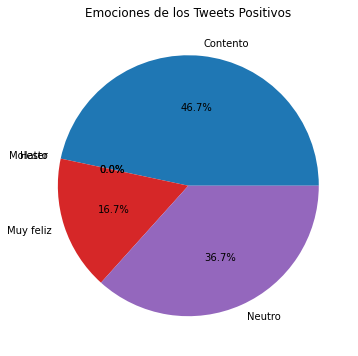

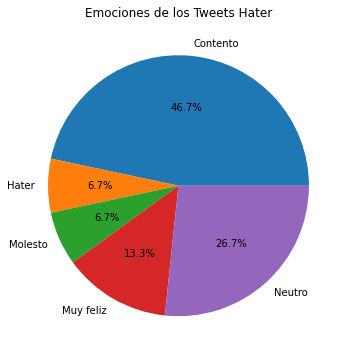

Porcentaje de emociones en los Tweets Positivos:
Contento : 0.4666666666666667
Hater : 0.0
Molesto : 0.0
Muy feliz : 0.16666666666666666
Neutro : 0.36666666666666664

Porcentaje de emociones en los Tweets Hater:
Contento : 0.4666666666666667
Hater : 0.06666666666666667
Molesto : 0.06666666666666667
Muy feliz : 0.13333333333333333
Neutro : 0.26666666666666666


In [26]:
if modelo == knn :
    
    predicciones_positivos = modelo.predict(selector.transform(vectorizer.transform(tweets_positivos)))
    predicciones_hater = modelo.predict(selector.transform(vectorizer.transform(tweets_hater)))

else:
    
    predicciones_positivos = modelo.predict(vectorizer.transform(tweets_positivos))
    predicciones_hater = modelo.predict(vectorizer.transform(tweets_hater))

# Calcular el porcentaje de cada etiqueta en las predicciones
porcentaje_positivos = {etiqueta: (predicciones_positivos == etiqueta).mean() for etiqueta in modelo.classes_}
porcentaje_hater = {etiqueta: (predicciones_hater == etiqueta).mean() for etiqueta in modelo.classes_}

# Generar el pie chart de las emociones
plt.figure(figsize=(6, 6))
plt.pie(list(porcentaje_positivos.values()), labels=list(porcentaje_positivos.keys()), autopct='%1.1f%%')
plt.title("Emociones de los Tweets Positivos")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(list(porcentaje_hater.values()), labels=list(porcentaje_hater.keys()), autopct='%1.1f%%')
plt.title("Emociones de los Tweets Hater")
plt.show()

print("Porcentaje de emociones en los Tweets Positivos:")
for etiqueta, porcentaje in porcentaje_positivos.items():
    print(etiqueta, ":", porcentaje)

print("\nPorcentaje de emociones en los Tweets Hater:")
for etiqueta, porcentaje in porcentaje_hater.items():
    print(etiqueta, ":", porcentaje)

Al analizar los pie chart se puede ver que la persona que hemos cogido con buena valoración social publica tweets que al menos los últimos 30 han sido positivos, ya que casi la mitad se han categorizado como "Contento" y sobre un 20% como "Muy feliz", siendo los restantes neutros. Esto se podía ver sin muchas complicaciones al leer la lista de sus tweets ya que muchos contienen mensajes de amor o agradecimientos a distintas personas. Sin embargo si lo comparamos con la persona que hemos cogido de hater se observa que este último escribe todo tipo de tweets al tener más de uno por categoría, aun así como en el caso anterior se puede decir que la mitad se consideran como "Contento", esto es así porque a pesar de subir mensajes en los que puede hacer una critica de forma negativa en su mayoría según sus tweets su estado de ánimo es en mayor parte neutro y contento. Esto último se puede explicar como que aunque haya personas que sean hater a veces es díficil encontrar una persona que su mayoría de tweets sean negativos.

En resumen, ha sido fácil buscar una persona con buena valoración social, pero tras estar buscando varias personas que nos pueda servir para este proyecto como hater hemos visto que a pesar de que tenga algún mensaje negativo siempre tendrá varios mensajes positivos o neutros al escribir o responder a su comunidad o a otras personas.

Finalmente, basándonos en los resultados obtenidos en este último apartado se puede llegar a la conclusión de que la persona escogida como hater no ha destacado precisamente por eso pese a tener algún tweet clasificado como "Molesto" o "Hater" al ser estos minoría. Por esto mismo se podría poner como un perfil en el que la mayoría de mensajes son neutros o contento, pero también realiza criticas y expresa opiniones negativas. 